In [1]:
using JSON

In [ ]:
using BenchmarkTools

In [2]:
struct Graph
    chains
    nodes
end

In [73]:
files = filter(x -> endswith(x, ".json"), readdir("json/"))

2-element Array{String,1}:
 "070506604.json"
 "087475936.json"

In [144]:
sort([3, 4], rev=true)

2-element Array{Int64,1}:
 4
 3

In [146]:
path = string("./json/", files[1])
data = read(path, String)
d = []
chains = JSON.parse( data, dicttype=Array{Array{String}});
sort!(chains, by=x->length(x), rev=true)
println(length(chains[1]))

33


In [147]:
# Define the graph
nodes_list = unique(n for ch in chains for n in ch)
nodes = Dict( n=>k for (k, n) in enumerate(nodes_list) )
println(length(nodes), " nodes")
println(length(chains), " chains")
graph = Graph(chains, nodes);

233 nodes
28 chains


In [148]:
# Search for intersections
intersections = Dict()
for (ch_idx, ch) in enumerate(graph.chains), n in ch
    el = get!(intersections, n, Int64[])
    push!(el, ch_idx)
    end;

filter!(x -> length(x[2]) > 1, intersections);
println(length(intersections), " intersections")
print(intersections)

52 intersections
Dict{Any,Any}("JDslf_2012_" => [5, 11],"SRG_2010_155546562" => [5, 11],"SC_2008_132816903" => [2, 7],"JdSLF_2012_168695693" => [5, 11],"RB_2008_140314512" => [2, 15],"PS_2009_14862295X" => [5, 13],"FS_2014_182322947" => [14, 23],"CC_2015_234828676" => [12, 17],"JH_2017_226365778" => [12, 16],"AB_2009_14700134X" => [9, 25],"MT_2018_233629068" => [10, 20],"MD_0_" => [6, 10, 20, 26],"LH_2013_18159563X" => [12, 28],"AHY_2005_099033143" => [16, 19],"SB_2011_167773925" => [1, 20],"ZM_0_" => [6, 8],"MR_2015_23484129X" => [11, 20],"AR_2010_15313237X" => [16, 19],"IM_2011_167762990" => [2, 15, 22],"BD_2007_115563423" => [3, 17],"AVA_0_" => [5, 13],"MB_2004_083809252" => [1, 14],"LM_2012_166231878" => [1, 10],"MA_2016_200037218" => [12, 18],"BT_2012_16959565X" => [5, 13],"IM_2017_" => [12, 17],"MG_2006_111484251" => [15, 19],"YT_2014_183073932" => [14, 27],"FD_2018_23551019X" => [5, 9],"LV_2012_167950827" => [1, 13],"LO_2001_059894881" => [1, 21],"MB_2017_225564041" => [10, 20],

In [149]:
# Place the first chain
function place_first_chain!(coords, graph, chain_idx=1) 
    chain = graph.chains[chain_idx]
    node_distance = 1.0f0

    chain_idx = map(x -> graph.nodes[x], chain);

    line = hcat([ [node_distance*(i-1); 0] for i in 1:length(chain)]...)
    coords[:, chain_idx] = line
    end;

In [150]:
function place_chain!(coords, graph, chain_idx)
# coords, graph, chain_idx

    # Check if the coordinates are not notching
    # i.e. if the node has been placed
    iscoordsdefined(n) = any(x->~isnothing(x), coords[:, graph.nodes[n]])

    #function get_knots(
    #coords, graph,   )
    chain = graph.chains[chain_idx]
    knots = [(idx_along_chain, coords[:, graph.nodes[n]])
                    for (idx_along_chain, n) in enumerate(chain)
                    if iscoordsdefined(n)]

    println("number of knots: ", length(knots))
    if length(knots)==0
        println("zero intersection")
        end;
    # si un seul noeud...
    # choisir une direction perpendiculoïde
    # si une seule chaine rencontrée
    # find nodes avant et après de cette chaine rencontrée
    if length(knots)==1
        idx_along_chain = knots[1][1]
        n = chain[idx_along_chain]

        other_chains = filter(i -> i != chain_idx, intersections[n])
        other_chain_id = other_chains[1]  # take the first anyway (TODO: multiple crossing...)

        other_chain = graph.chains[other_chain_id]
        idx_along_other_chain = findfirst(isequal(n), other_chain)

        coords_other_chain(idx) = coords[:, graph.nodes[other_chain[ idx ]]]

        println("intersection with chain #", other_chain_id,
            " at node #", idx_along_other_chain)

        # Define a normal direction
        if idx_along_other_chain == 1
            before = coords[:, graph.nodes[other_chain[1]]]
            next = coords[:, graph.nodes[other_chain[2]]]
        elseif idx_along_other_chain == length(other_chain)
            before = coords[:, graph.nodes[other_chain[end-1]]]
            next = coords[:, graph.nodes[other_chain[end]]]
        else
            before = coords[:, graph.nodes[other_chain[idx_along_other_chain-1]]]
            next = coords[:, graph.nodes[other_chain[idx_along_other_chain]]]
            end;

        # normal direction:
        u = next .- before
        norm = sqrt(u[1]^2 + u[2]^2)
        direction = [u[2]/norm; -u[1]/norm]

        # ajoute un noeud
        # si ce n'est pas le dernier alors le suivant
        # sinon le precedent
        # TODO: make a random choice, left or right?
        coords_n = knots[1][2]
        if idx_along_chain < length(chain)
            push!(knots, (idx_along_chain+1, coords_n .+ direction))
        else
            push!(knots, (idx_along_chain-1, coords_n .- direction))
            end;

        end;

    ##println("knots: ", knots)
    # Lagrange interpolation
    el(j, x) = prod(m -> if (j != m); (x - knots[m][1])/(knots[j][1] - knots[m][1]) else 1 end, 1:length(knots))
    L(x) = sum(j -> knots[j][2].*el(j, x), 1:length(knots))

    x = range(1, length(chain), step=1)


    idx_chain = map(x -> graph.nodes[x], chain); # not the same as chain_idx unfortunatly
    coords[:, idx_chain] = hcat(L.(x)...)
    end;

In [151]:
# get intersecting chains
function get_intersected(chain_id)
    chain = graph.chains[chain_id]
    intersected = Set{Int64}()
    for n in chain
        union!(intersected, get(intersections, n, []))
        end;
    setdiff!(intersected, chain_id)
    return sort(collect(intersected), by=x->length(graph.chains[x]), rev=true)
    end;

In [152]:
# Init empty coords array
coords = Array{Union{Nothing, Float32}}(nothing, 2, length(graph.nodes))

place_first_chain!(coords, graph)
added_chain = [1, ]
chains_to_add = get_intersected(1);

In [163]:
next_chain = pop!(chains_to_add)
println("add chain #", next_chain, "  ", chains_to_add)
place_chain!(coords, graph, next_chain)
push!(added_chain, next_chain)
println("added_chain", added_chain)

append!(chains_to_add, filter(x -> ~(x in added_chain),
        get_intersected(next_chain)))
println("chains_to_add  ", chains_to_add)
# loop

add chain #12  [10, 14, 13, 12, 20, 21, 7, 8, 15, 8, 15, 15]
number of knots: 2
added_chain[1, 24, 2, 22, 19, 16, 12]
chains_to_add  [10, 14, 13, 12, 20, 21, 7, 8, 15, 8, 15, 15, 18, 17, 28]


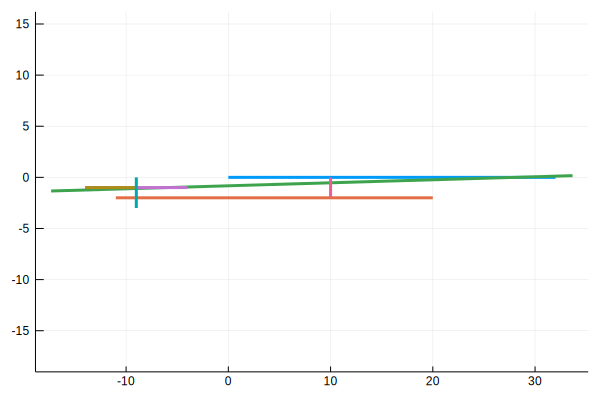

In [164]:
fig = plot(legend=false, aspect_ratio=:equal)
#scatter!(coords[:, 1], coords[:, 2], linewidth=2)
for chain in graph.chains
    chain_idx = map(x -> graph.nodes[x], chain);
    x = coords[1, chain_idx]
    y = coords[2, chain_idx]
    if ~any(isnothing, x)
        plot!(x, y, linewidth=3)
        end;
    #println(coords[idx, 1])
    end;
fig

In [32]:
using(Plots)

┌ Info: Recompiling stale cache file /home/etienne/.julia/compiled/v1.2/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240
